In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


import sys

sys.path.append('../')

from eda import utils

In [534]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
feats = utils.load('../data/fma_metadata/features.csv')

In [794]:
small = tracks['set', 'subset'] <= 'small'

X = feats.loc[small]
y = tracks['track', 'genre_top'].loc[small]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [795]:
sc = StandardScaler()
X_train2 = X_train.copy()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'relu', learning_rate_init = 0.1, batch_size = 300, hidden_layer_sizes = (200,100), max_iter = 100)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [537]:
print(mlp.classes_)

['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


Accuracy: 0.58375
               precision    recall  f1-score   support

   Electronic       0.56      0.58      0.57       173
 Experimental       0.47      0.51      0.49       195
         Folk       0.66      0.61      0.63       206
      Hip-Hop       0.62      0.67      0.64       199
 Instrumental       0.55      0.57      0.56       201
International       0.69      0.71      0.70       204
          Pop       0.44      0.36      0.39       214
         Rock       0.65      0.67      0.66       208

     accuracy                           0.58      1600
    macro avg       0.58      0.58      0.58      1600
 weighted avg       0.58      0.58      0.58      1600



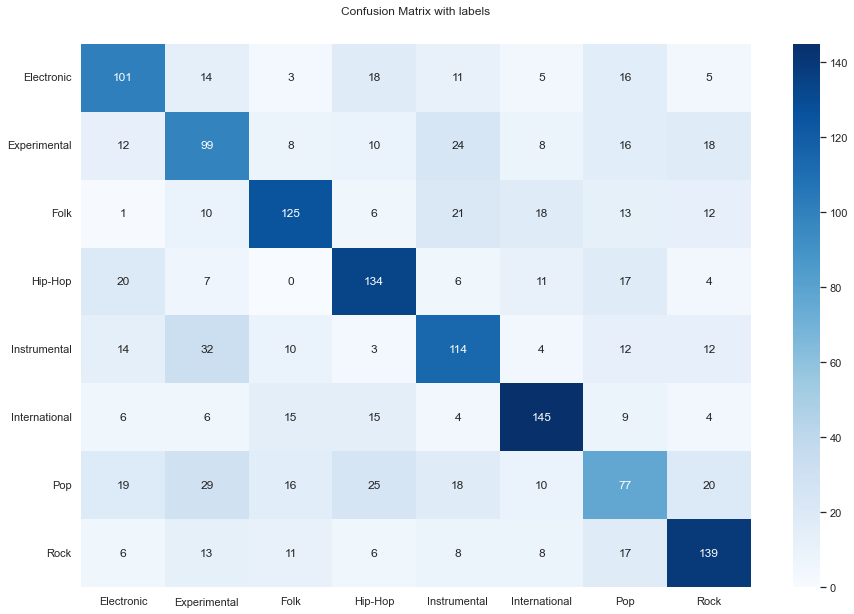

In [796]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

In [546]:
from sklearn.model_selection import GridSearchCV

learning_rate_init = [0.1, 0.2, 0.3]
max_iter = [100, 300]
hidden_layer_sizes = [(200,100), (200,50), (100,50)]
solver = ['sgd']
random_state = [42]
activation = ['logistic', 'relu']
batch_size = [100, 300]


# Make a dictionary of the grid search parameters
param_grid = dict(learning_rate_init=learning_rate_init, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes, solver=solver, random_state=random_state, activation=activation, batch_size=batch_size)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=mlp, param_grid=param_grid)

grid.fit(X_train, y_train)
print(grid.best_params_)

c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\en

{'activation': 'logistic', 'batch_size': 100, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.2, 'max_iter': 100, 'random_state': 42, 'solver': 'sgd'}


Accuracy: 0.58
               precision    recall  f1-score   support

   Electronic       0.61      0.60      0.60       201
 Experimental       0.47      0.48      0.48       191
         Folk       0.64      0.62      0.63       206
      Hip-Hop       0.67      0.68      0.68       198
 Instrumental       0.51      0.62      0.56       202
International       0.70      0.68      0.69       210
          Pop       0.37      0.34      0.35       194
         Rock       0.67      0.61      0.64       198

     accuracy                           0.58      1600
    macro avg       0.58      0.58      0.58      1600
 weighted avg       0.58      0.58      0.58      1600



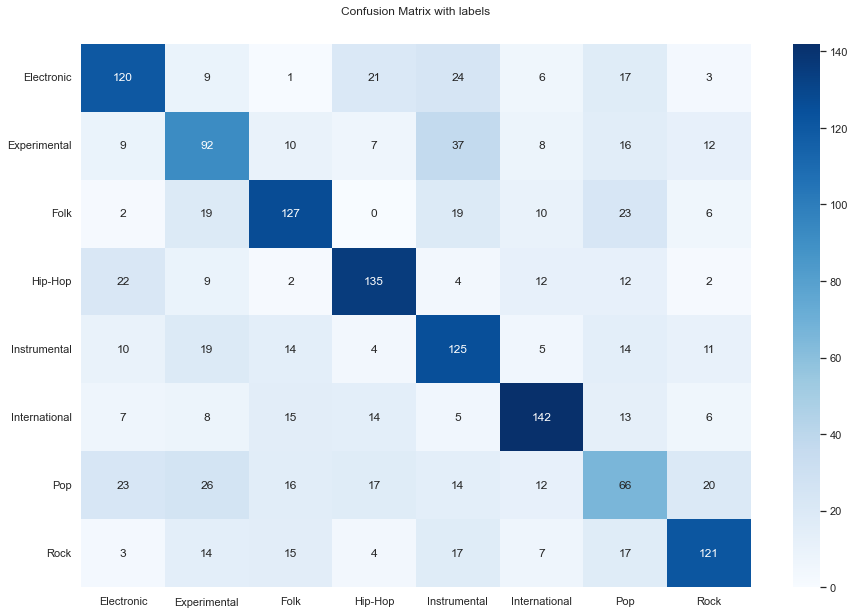

In [547]:
grid_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, grid_pred))
print(classification_report(y_test, grid_pred))
cf_mat = confusion_matrix(y_test, grid_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

In [548]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import pandas as pd
from scipy import stats
from pandas import DataFrame
import random

In [788]:
#filename = "../feature extraction/files/1.mp3"
#filename = "../feature extraction/files/2.mp3"
#filename = "../feature extraction/files/3.mp3"
#filename = "../feature extraction/files/4.mp3"
#filename = "../feature extraction/files/5.mp3"
filename = "../feature extraction/files/6.mp3"

print('File: {}'.format(filename))
x, sr = librosa.load(filename, sr=None, mono=True)

#print(x.shape[-1]/sr)
if (x.shape[-1]/sr > 30):
    start = random.randint(0, int(x.shape[-1]/sr)-30)
    duration = 30
else:
    start = 0
    duration = x.shape[-1]/sr
#print(start)

#x, sr = librosa.load(filename, sr=None, mono=True, offset=start, duration=duration)

print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

File: ../feature extraction/files/6.mp3


c:\Users\micha\anaconda3\envs\env1\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Duration: 51.46s, 2269184 samples


In [789]:
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    return columns.sort_values()

In [790]:
features = pd.Series(index=columns(), dtype=np.float32)

def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

In [791]:
f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
feature_stats('zcr', f)

cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
assert cqt.shape[0] == 7 * 12
assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cqt', f)
f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cens', f)
f = librosa.feature.tonnetz(chroma=f)
feature_stats('tonnetz', f)

del cqt
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
assert stft.shape[0] == 1 + 2048 // 2
assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
del x

f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
feature_stats('chroma_stft', f)

f = librosa.feature.rms(S=stft)
feature_stats('rmse', f)

f = librosa.feature.spectral_centroid(S=stft)
feature_stats('spectral_centroid', f)
f = librosa.feature.spectral_bandwidth(S=stft)
feature_stats('spectral_bandwidth', f)
f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
feature_stats('spectral_contrast', f)
f = librosa.feature.spectral_rolloff(S=stft)
feature_stats('spectral_rolloff', f)

mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
del stft
f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
feature_stats('mfcc', f)

In [792]:
features = features.to_frame().T
print(features.shape)

(1, 518)


In [793]:
sc.fit(X_train2)
features = sc.transform(features)
#print(features)
mlpprediction = mlp.predict(features)
print(mlpprediction)
bestprediction = grid.predict(features)
print(bestprediction)

['Pop']
['Folk']
